# Model Comparison in The Domain of Brain Tumor Image Classification  
For our final project for Spring 2025, CS 4644 - Deep Learning, we analyze and compare the results from three unique models:  
1. 3D CNN - Turning 2D images into 3D datapoints to reconstruct a full brain image.  
2. ResNet18 - Applying transfer learning by taking a pretrained ResNet-18 model (trained on ImageNet) and adapting it to MRI scans through the fine-tuning of a final fully connected layer.  
3. Inception - Applying transfer learning in the same way as ResNet, but for another popular and successful model.  
  
The following code allows the reader to experiment with these 3 models and observe their results.

# Step 0: Get necessary imports, set global variables, and setup dataset

In [1]:
# Basic imports
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
from PIL import Image
import matplotlib.pyplot as plt

from src import (
    get_optimizer,
    Trainer,
)
from src.models import (
    CNN_3D,
    MyResNet,
    MyInception
)
from data.data_transforms import (
    get_fundamental_transforms,
    get_fundamental_normalization_transforms,
    get_fundamental_augmentation_transforms,
    get_all_transforms,
)
from utils.confusion_matrix import (
    generate_confusion_data,
    generate_confusion_matrix,
    plot_confusion_matrix,
    get_pred_images_for_target,
    generate_and_plot_confusion_matrix,
    generate_and_plot_accuracy_table,
)
from utils.utils import save_trained_model_weights
from utils.dataset_utils import prepare_dataset

#Folder paths
raw_data_path = "../data/raw/"
data_path = "../data/processed/"
model_path = "../src/models/"
results_path = "../results/"

# Global Variables
batch_size = 32
num_classes = 3 # Output classes: Pituitary, Meningioma, and Glioma Tumor
n_slices = 1 # TODO for 3D CNN: Change this if we find a pattern in the dataset for determining multiple images go to same patient

%load_ext autoreload
%autoreload 2

d:\CS 4644 Project\TumorTrace\utils\dataset_utils.py:52: SyntaxWarning: invalid escape sequence '\.'
  "mkdir %USERPROFILE%\.kaggle\n"
d:\CS 4644 Project\TumorTrace\utils\dataset_utils.py:53: SyntaxWarning: invalid escape sequence '\D'
  "move %USERPROFILE%\Downloads\kaggle.json %USERPROFILE%\.kaggle\ \n"


### Download the dataset, preprocess it, and compute statistics

In [5]:
dataset_mean, dataset_std = prepare_dataset(
    raw_data_path=raw_data_path,
    pickle_path= os.path.join(raw_data_path, "brain_tumor_mri/new_dataset/training_data.pickle"),
    processed_data_path=data_path,
    n_slices=n_slices, # TODO: figure out how many images in a row make up a 3d datapoint
)

[INFO] Raw data already exists. Skipping Kaggle download.
[INFO] Processed data directory already exists. Skipping conversion.
[INFO] Loading cached dataset mean and std...


d:\CS 4644 Project\TumorTrace\utils\dataset_utils.py:52: SyntaxWarning: invalid escape sequence '\.'
  "mkdir %USERPROFILE%\.kaggle\n"
d:\CS 4644 Project\TumorTrace\utils\dataset_utils.py:53: SyntaxWarning: invalid escape sequence '\D'
  "move %USERPROFILE%\Downloads\kaggle.json %USERPROFILE%\.kaggle\ \n"


# Step 1: Test 3D Convolutional Nerual Network

In [10]:
inp_size = (n_slices, 512, 512)

In [11]:
model_cnn = CNN_3D(inp_size, num_classes=num_classes)

cnn_optimizer_config = {"optimizer_type": "adam", "lr": 1e-3, "weight_decay": 1e-8} # Tune these
cnn_optimizer = get_optimizer(model_cnn, cnn_optimizer_config)

cnn_trainer = Trainer(
    data_dir=data_path,
    model=model_cnn,
    optimizer=cnn_optimizer,
    model_dir=os.path.join(model_path, "CNN_3D"),
    train_data_transforms=get_all_transforms(tuple((inp_size[1], inp_size[2])), [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        tuple((inp_size[1], inp_size[2])), [dataset_mean], [dataset_std]
    ),
    batch_size=batch_size,
    load_from_disk=False,
    cuda=torch.cuda.is_available(),
    n_slices=n_slices,
)

In [18]:
%%time
cnn_trainer.run_training_loop(num_epochs=5)

Minibatch:1 Train Loss:0.0351 Val Loss: 0.0351 Train Accuracy: 0.4688 Validation Accuracy: 0.4688
Minibatch:2 Train Loss:0.2217 Val Loss: 0.2217 Train Accuracy: 0.5312 Validation Accuracy: 0.5312
Minibatch:3 Train Loss:0.1824 Val Loss: 0.1824 Train Accuracy: 0.2812 Validation Accuracy: 0.2812
Minibatch:4 Train Loss:0.0747 Val Loss: 0.0747 Train Accuracy: 0.3125 Validation Accuracy: 0.3125
Minibatch:5 Train Loss:0.0223 Val Loss: 0.0223 Train Accuracy: 0.7188 Validation Accuracy: 0.7188
Minibatch:6 Train Loss:0.0293 Val Loss: 0.0293 Train Accuracy: 0.5938 Validation Accuracy: 0.5938
Minibatch:7 Train Loss:0.0303 Val Loss: 0.0303 Train Accuracy: 0.4375 Validation Accuracy: 0.4375
Minibatch:8 Train Loss:0.0272 Val Loss: 0.0272 Train Accuracy: 0.5938 Validation Accuracy: 0.5938
Minibatch:9 Train Loss:0.0323 Val Loss: 0.0323 Train Accuracy: 0.4375 Validation Accuracy: 0.4375
Minibatch:10 Train Loss:0.0309 Val Loss: 0.0309 Train Accuracy: 0.5625 Validation Accuracy: 0.5625
Minibatch:11 Train 

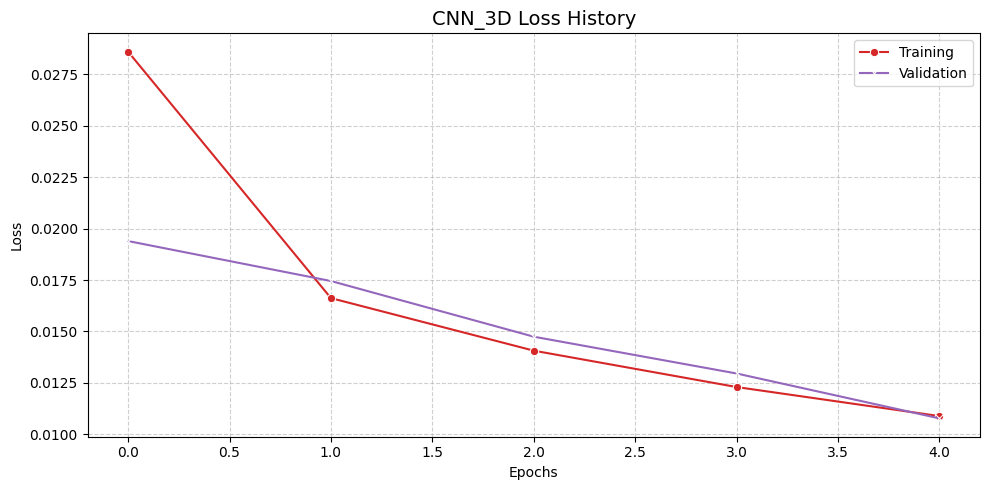

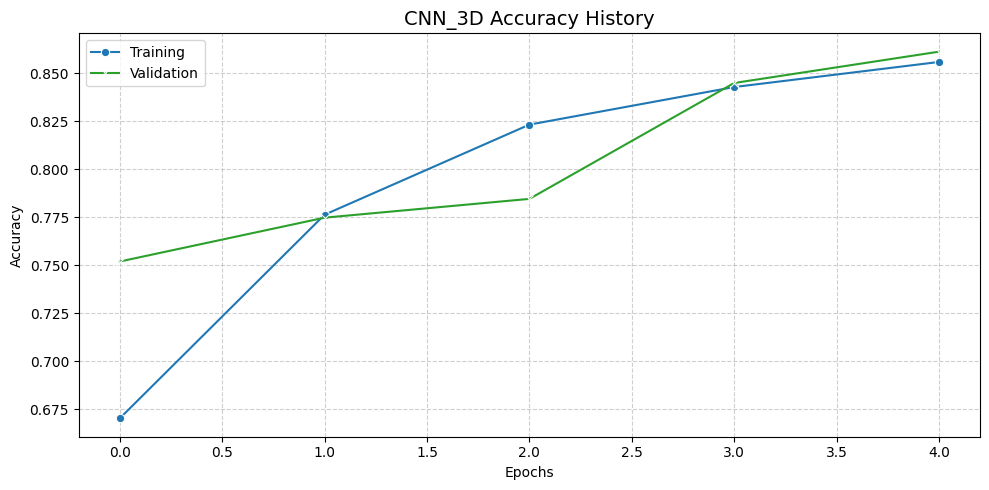

Train Accuracy = 0.8559771522314196; Validation Accuracy = 0.8613376836208885


In [19]:
cnn_trainer.plot_loss_history()
cnn_trainer.plot_accuracy()
train_accuracy = cnn_trainer.train_accuracy_history[-1]
validation_accuracy = cnn_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

In [20]:
save_trained_model_weights(model_cnn, out_dir=os.path.join(model_path, "CNN_3D"))

Saved training plots to ../src/models/CNN_3D/trained_CNN_3D_final.pt


# Step 2: Test ResNet Pretrained Model

In [12]:
inp_size = (224, 224)

In [13]:
model_resnet = MyResNet(num_classes=num_classes)

resnet_optimizer_config = {"optimizer_type": "adam", "lr": 1e-4, "weight_decay": 1e-8} # Tune these
resnet_optimizer = get_optimizer(model_resnet, resnet_optimizer_config)

resnet_trainer = Trainer(
    data_dir=data_path,
    model=model_resnet,
    optimizer=resnet_optimizer,
    model_dir=os.path.join(model_path, "ResNet"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=batch_size,
    load_from_disk=False,
    cuda=torch.cuda.is_available(),
)

In [23]:
%%time
resnet_trainer.run_training_loop(num_epochs=50)

Minibatch:1 Train Loss:0.0334 Val Loss: 0.0334 Train Accuracy: 0.4062 Validation Accuracy: 0.4062
Minibatch:2 Train Loss:0.0346 Val Loss: 0.0346 Train Accuracy: 0.3438 Validation Accuracy: 0.3438
Minibatch:3 Train Loss:0.0335 Val Loss: 0.0335 Train Accuracy: 0.4688 Validation Accuracy: 0.4688
Minibatch:4 Train Loss:0.0311 Val Loss: 0.0311 Train Accuracy: 0.6875 Validation Accuracy: 0.6875
Minibatch:5 Train Loss:0.0322 Val Loss: 0.0322 Train Accuracy: 0.5625 Validation Accuracy: 0.5625
Minibatch:6 Train Loss:0.0338 Val Loss: 0.0338 Train Accuracy: 0.4375 Validation Accuracy: 0.4375
Minibatch:7 Train Loss:0.0323 Val Loss: 0.0323 Train Accuracy: 0.5625 Validation Accuracy: 0.5625
Minibatch:8 Train Loss:0.0343 Val Loss: 0.0343 Train Accuracy: 0.3125 Validation Accuracy: 0.3125
Minibatch:9 Train Loss:0.0311 Val Loss: 0.0311 Train Accuracy: 0.5625 Validation Accuracy: 0.5625
Minibatch:10 Train Loss:0.0324 Val Loss: 0.0324 Train Accuracy: 0.4688 Validation Accuracy: 0.4688
Minibatch:11 Train 

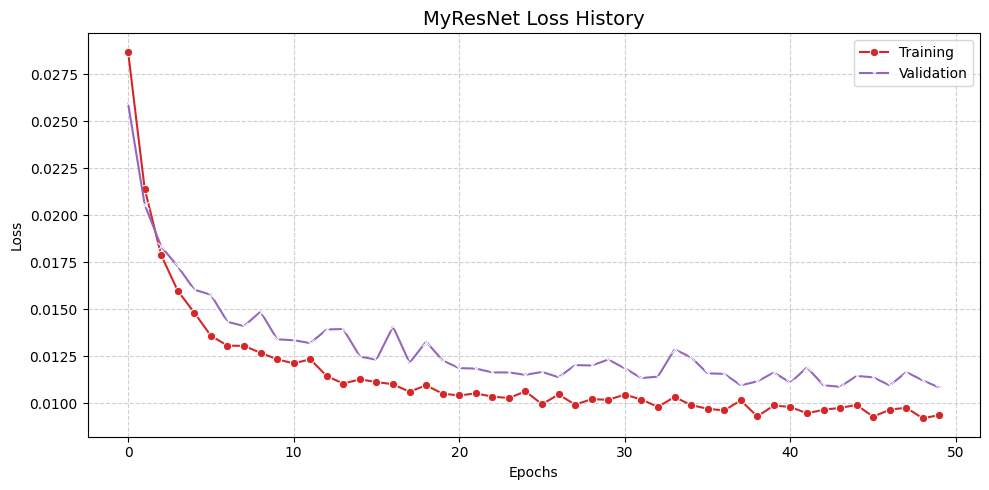

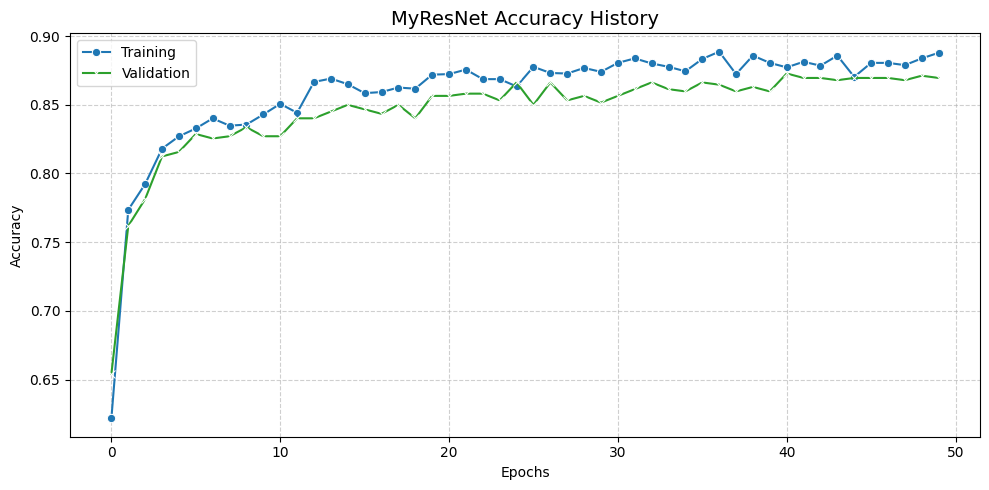

Train Accuracy = 0.8878008977630487; Validation Accuracy = 0.8694942904724382


In [24]:
resnet_trainer.plot_loss_history()
resnet_trainer.plot_accuracy()
train_accuracy = resnet_trainer.train_accuracy_history[-1]
validation_accuracy = resnet_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

In [25]:
save_trained_model_weights(model_resnet, out_dir=os.path.join(model_path, "ResNet"))

Saved training plots to ../src/models/ResNet/trained_MyResNet_final.pt


# Step 3: Test Inception Pretrained Model

In [33]:
inp_size = (299,299)

In [34]:
model_inception = MyInception(num_classes=num_classes)

inception_optimizer_config = {"optimizer_type": "adam", "lr": 1e-4, "weight_decay": 1e-8} # Tune these
inception_optimizer = get_optimizer(model_inception, inception_optimizer_config)

inception_trainer = Trainer(
    data_dir=data_path,
    model=model_inception,
    optimizer=inception_optimizer,
    model_dir=os.path.join(model_path, "Inception"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=batch_size,
    load_from_disk=False,
    cuda=torch.cuda.is_available(),
)

c:\Users\Ipwn9\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
%%time
inception_trainer.run_training_loop(num_epochs=20)

Minibatch:1 Train Loss:0.0341 Val Loss: 0.0341 Train Accuracy: 0.4062 Validation Accuracy: 0.4062
Minibatch:2 Train Loss:0.0343 Val Loss: 0.0343 Train Accuracy: 0.4062 Validation Accuracy: 0.4062
Minibatch:3 Train Loss:0.0344 Val Loss: 0.0344 Train Accuracy: 0.3125 Validation Accuracy: 0.3125
Minibatch:4 Train Loss:0.0337 Val Loss: 0.0337 Train Accuracy: 0.3750 Validation Accuracy: 0.3750
Minibatch:5 Train Loss:0.0342 Val Loss: 0.0342 Train Accuracy: 0.4062 Validation Accuracy: 0.4062
Minibatch:6 Train Loss:0.0333 Val Loss: 0.0333 Train Accuracy: 0.4375 Validation Accuracy: 0.4375
Minibatch:7 Train Loss:0.0341 Val Loss: 0.0341 Train Accuracy: 0.3750 Validation Accuracy: 0.3750
Minibatch:8 Train Loss:0.0324 Val Loss: 0.0324 Train Accuracy: 0.3750 Validation Accuracy: 0.3750
Minibatch:9 Train Loss:0.0326 Val Loss: 0.0326 Train Accuracy: 0.5312 Validation Accuracy: 0.5312
Minibatch:10 Train Loss:0.0343 Val Loss: 0.0343 Train Accuracy: 0.4062 Validation Accuracy: 0.4062
Minibatch:11 Train 

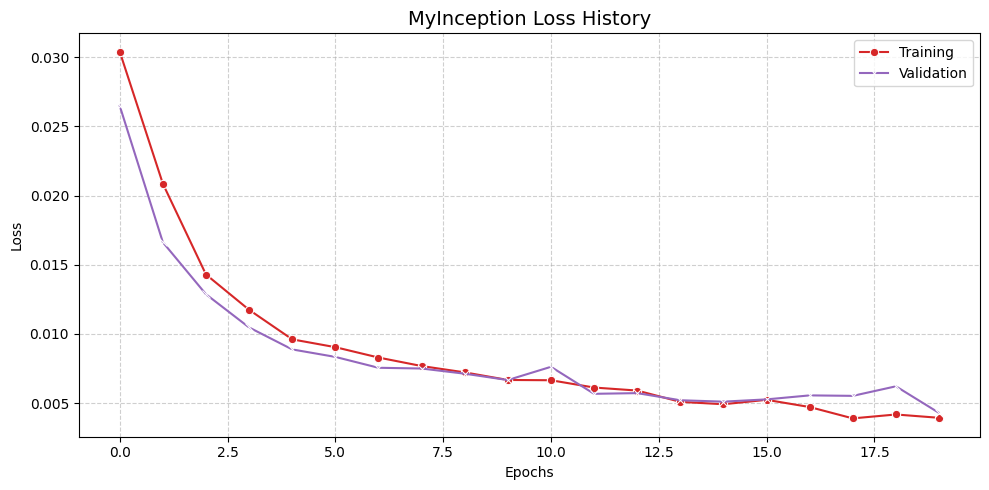

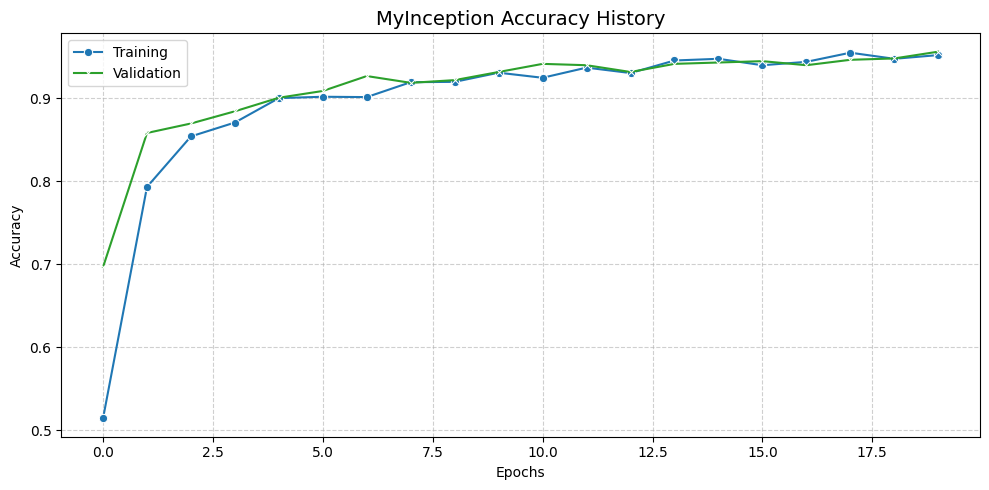

Train Accuracy = 0.9518563851489188; Validation Accuracy = 0.9559543230016313


In [36]:
inception_trainer.plot_loss_history()
inception_trainer.plot_accuracy()
train_accuracy = inception_trainer.train_accuracy_history[-1]
validation_accuracy = inception_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

In [37]:
save_trained_model_weights(model_inception, out_dir=os.path.join(model_path, "Inception"))

Saved training plots to ../src/models/Inception/trained_MyInception_final.pt


# Step 4: Analyze Graphs and Final Accuracies

### Model Parameters

In [38]:
print('3D CNN:', model_cnn.count_parameters())
print('ResNet:', model_resnet.count_parameters())
print('Inception:', model_inception.count_parameters())

3D CNN: 1127063
ResNet: 11228115
Inception: 2447598


### Classification Results

In [39]:
#cnn_trainer.print_classification_report()
#resnet_trainer.print_classification_report()
inception_trainer.print_classification_report()


Classification Report:

              precision    recall  f1-score   support

      Glioma       0.96      0.97      0.96       186
  Meningioma       0.96      0.98      0.97       285
   Pituitary       0.94      0.89      0.91       142

    accuracy                           0.96       613
   macro avg       0.95      0.95      0.95       613
weighted avg       0.96      0.96      0.96       613

Macro F1 Score: 0.9493


### Loss & Accuracy Graphs

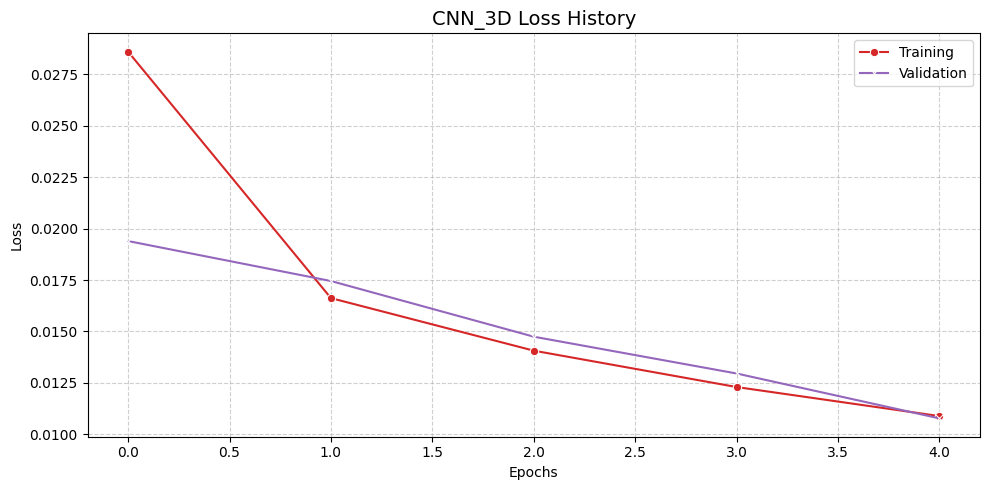

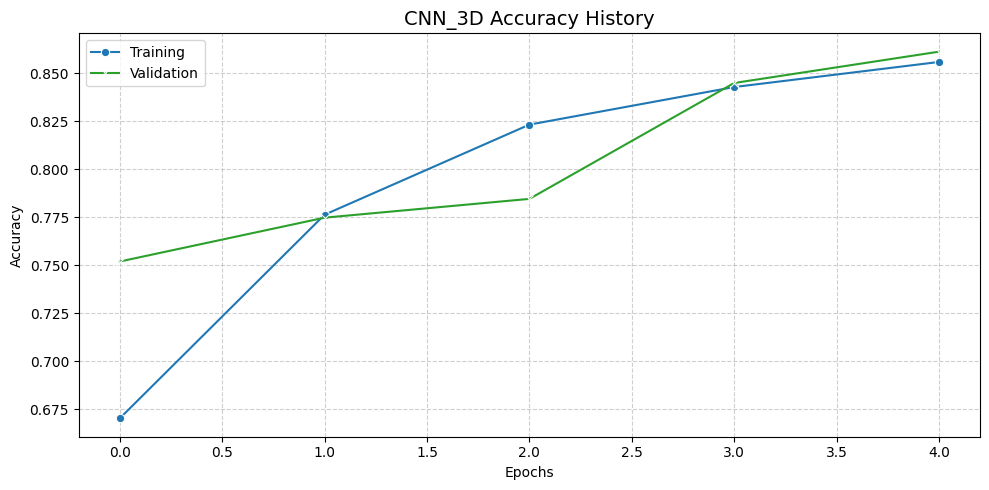

Train Accuracy = 0.8559771522314196; Validation Accuracy = 0.8613376836208885


In [28]:
cnn_trainer.plot_loss_history()
cnn_trainer.plot_accuracy()
train_accuracy = cnn_trainer.train_accuracy_history[-1]
validation_accuracy = cnn_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

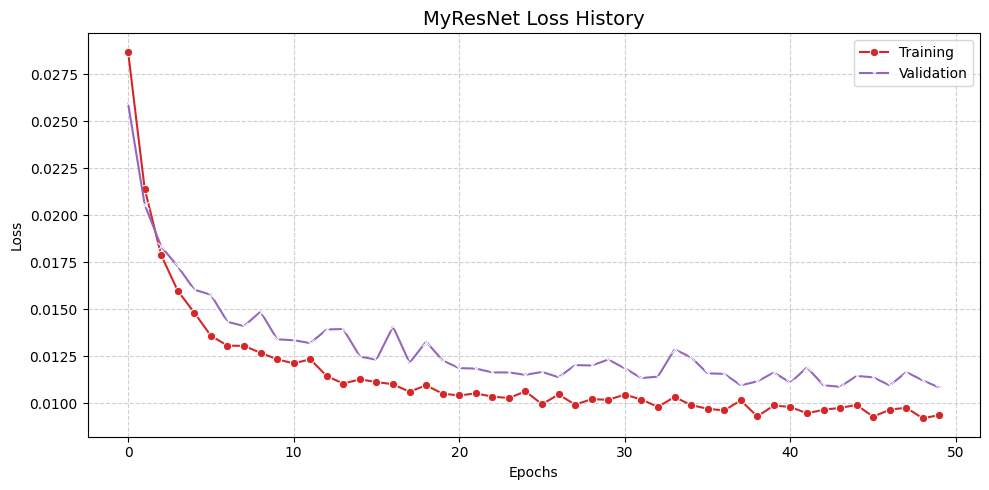

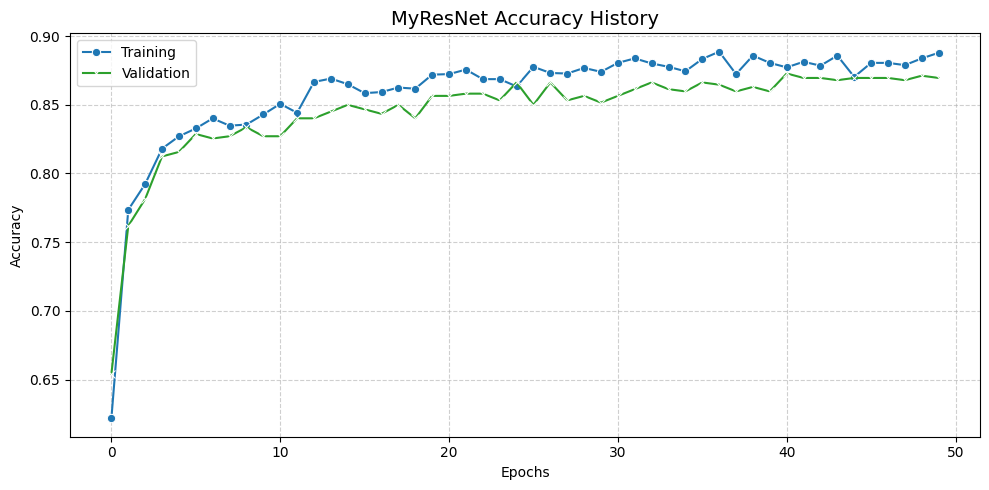

Train Accuracy = 0.8878008977630487; Validation Accuracy = 0.8694942904724382


In [29]:
resnet_trainer.plot_loss_history()
resnet_trainer.plot_accuracy()
train_accuracy = resnet_trainer.train_accuracy_history[-1]
validation_accuracy = resnet_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

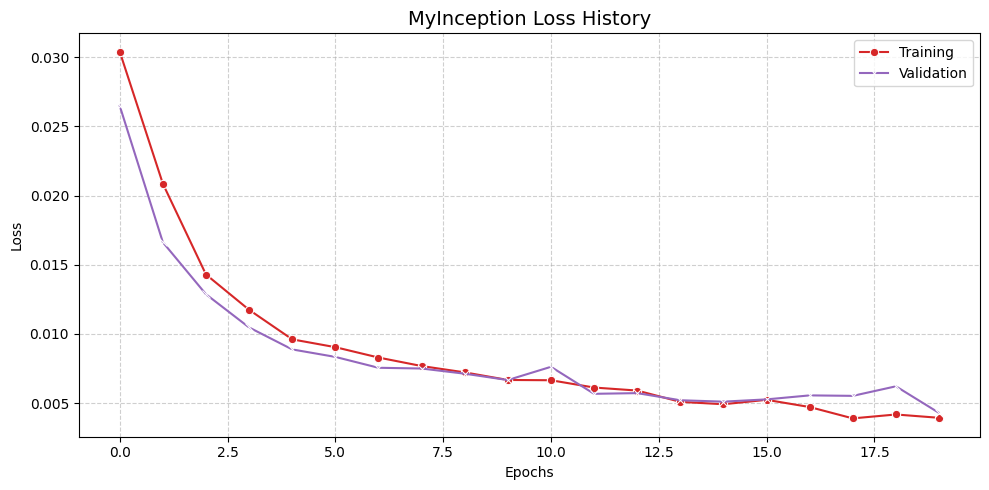

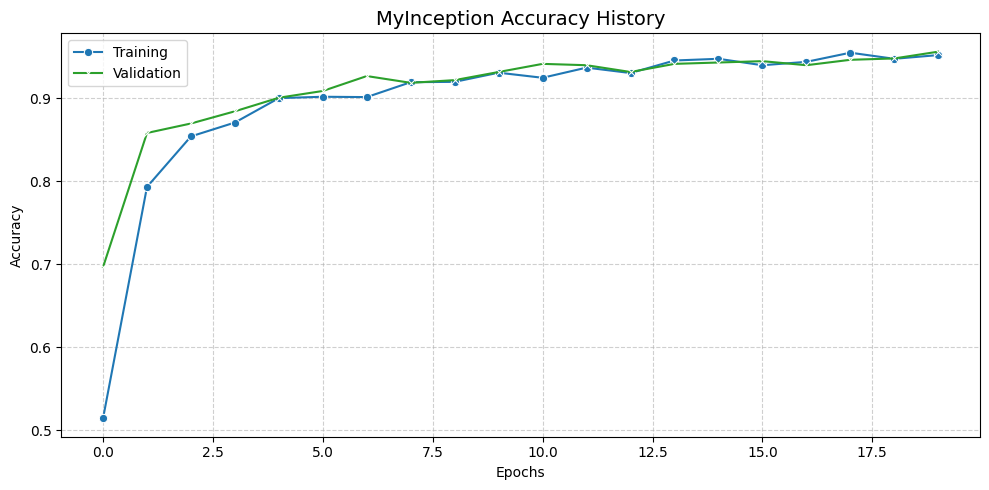

Train Accuracy = 0.9518563851489188; Validation Accuracy = 0.9559543230016313


In [40]:
inception_trainer.plot_loss_history()
inception_trainer.plot_accuracy()
train_accuracy = inception_trainer.train_accuracy_history[-1]
validation_accuracy = inception_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

### Confusion Matrices

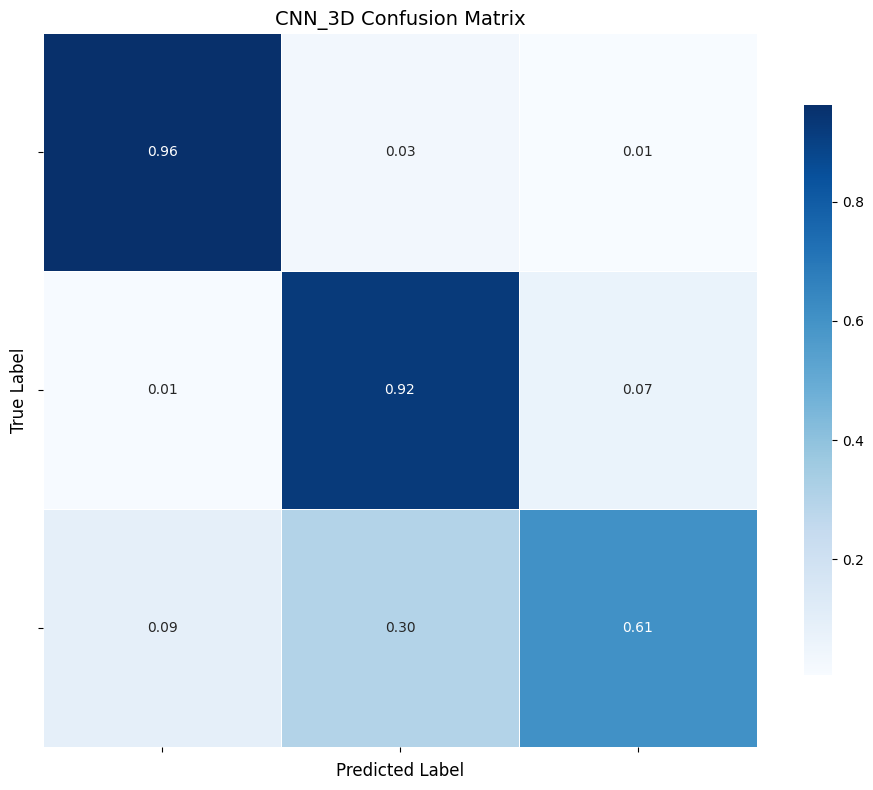

In [31]:
generate_and_plot_confusion_matrix(model_cnn, cnn_trainer.val_dataset, path=results_path, use_cuda=torch.cuda.is_available())

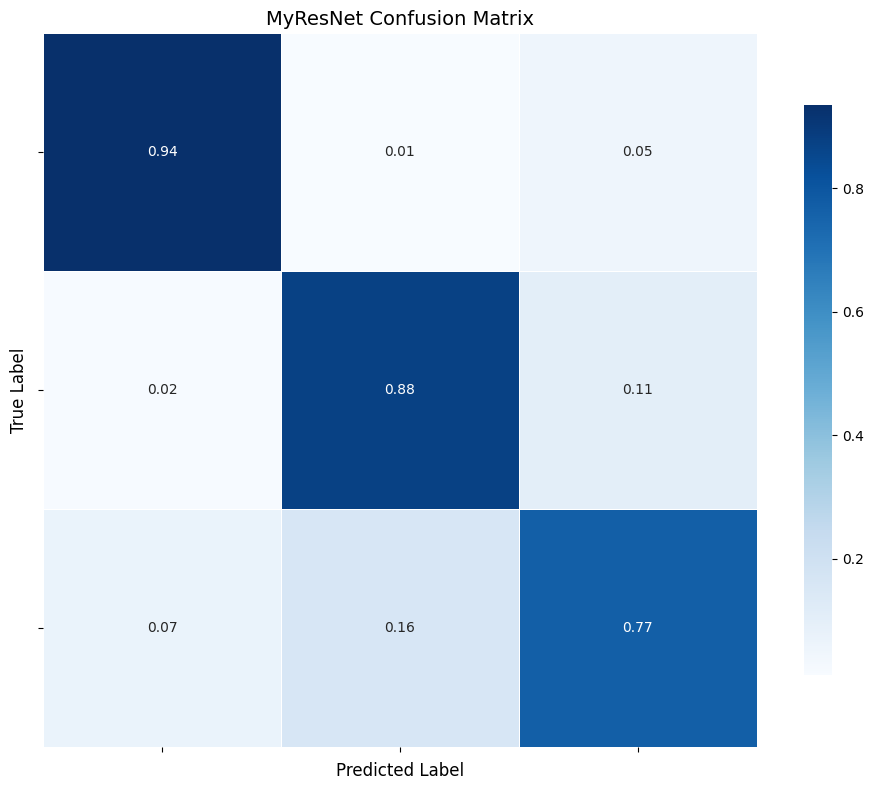

In [32]:
generate_and_plot_confusion_matrix(model_resnet, resnet_trainer.val_dataset, path=results_path, use_cuda=torch.cuda.is_available())

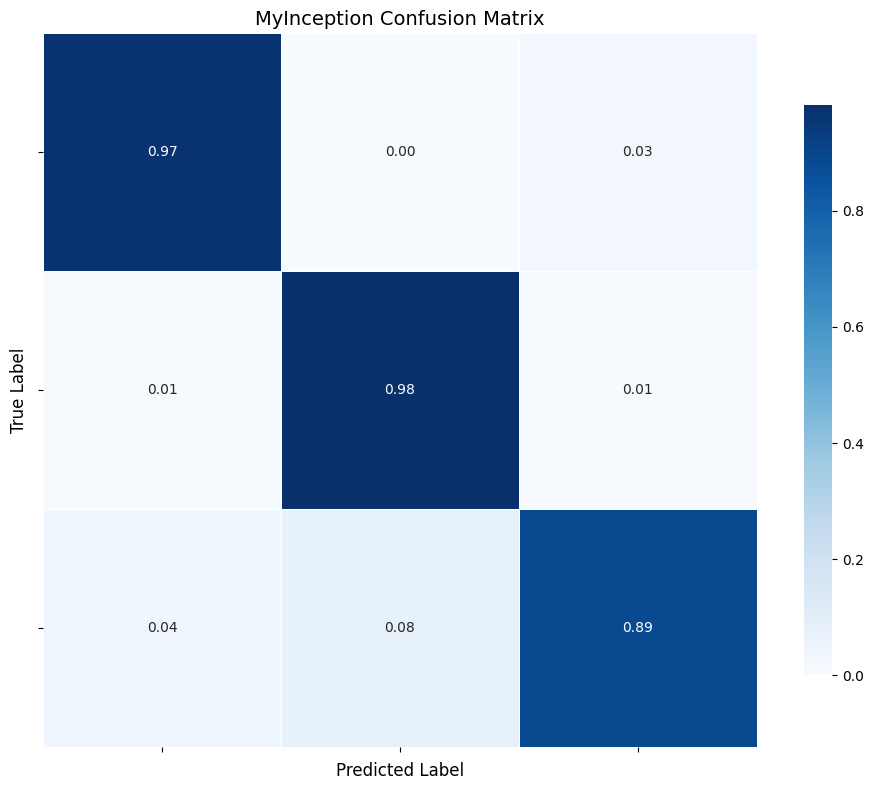

In [41]:
generate_and_plot_confusion_matrix(model_inception, inception_trainer.val_dataset, path=results_path, use_cuda=torch.cuda.is_available())

### Analyze errors that occurred from confusion matrix

{'Glioma': 0, 'Meningioma': 1, 'Pituitary': 2}


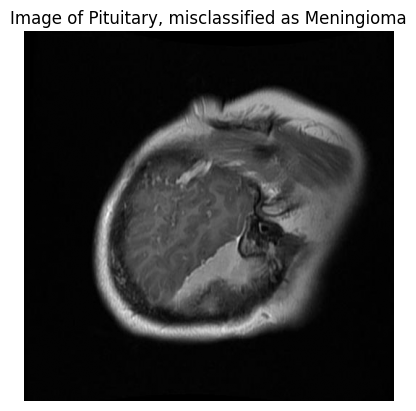

In [42]:
trainer = inception_trainer # Change this
model = model_inception # Change this

predicted_class_num = 1
true_class_num = 2
correct_class = [k for k, v in trainer.val_dataset.class_dict.items() if v == true_class_num][0]
pred_class = key = [k for k, v in trainer.val_dataset.class_dict.items() if v == predicted_class_num][0]
print(trainer.val_dataset.class_dict)

paths = get_pred_images_for_target(model, trainer.val_dataset, predicted_class_num, true_class_num, torch.cuda.is_available())
max_count = 1
count = 0
for path in paths:
    img = Image.open(path).convert(mode='L')
    if (count != max_count):
        plt.imshow(img, cmap='gray')
        plt.title(f'Image of {correct_class}, misclassified as {pred_class}')
        plt.axis('off')  # Removes axis ticks
        plt.savefig(os.path.join(results_path, f'{model.__class__.__name__}_misclassified.png')),
        plt.show()
        count += 1